In [1]:
!pip install ultralytics
!pip install shapely


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import shutil
import ultralytics
import os

# Replace the installed ultralytics with the local ultralytics
installed_path = r"D:\Py\envs\seg\Lib\site-packages\ultralytics"
local_path = r"C:\Users\shin chen\Desktop\WanderPal\code\SI_code\ultralytics"
shutil.rmtree(installed_path)
shutil.copytree(local_path, installed_path)

import importlib
importlib.reload(ultralytics)

print(f"ultralytics has been replaced with：{ultralytics.__file__}")

ultralytics has been replaced with：c:\Users\shin chen\Desktop\WanderPal\code\SI_code\ultralytics\__init__.py


In [3]:
import cv2
import os
from PIL import Image
from ultralytics import YOLO
from shapely.geometry import Polygon, box
import matplotlib.pyplot as plt
import numpy as np

In [6]:
model = YOLO(r"C:\Users\shin chen\Desktop\WanderPal\code\SI_code\best.pt")
# accepts all formats - image/dir/Path/URL/video/PIL/ndarray. 0 for webcam
results = model.predict(source=r"C:\Users\shin chen\Desktop\WanderPal\code\SI_code\output_images\frame_16.jpg",imgsz=320,save = True, conf=0.1)
# results = model.predict(source="folder", show=True)  # Display preds. Accepts all YOLO predict arguments


image 1/1 C:\Users\shin chen\Desktop\WanderPal\code\SI_code\output_images\frame_16.jpg: 192x320 (no detections), 137.2ms
Speed: 1.0ms preprocess, 137.2ms inference, 0.0ms postprocess per image at shape (1, 3, 192, 320)
Results saved to runs\segment\predict


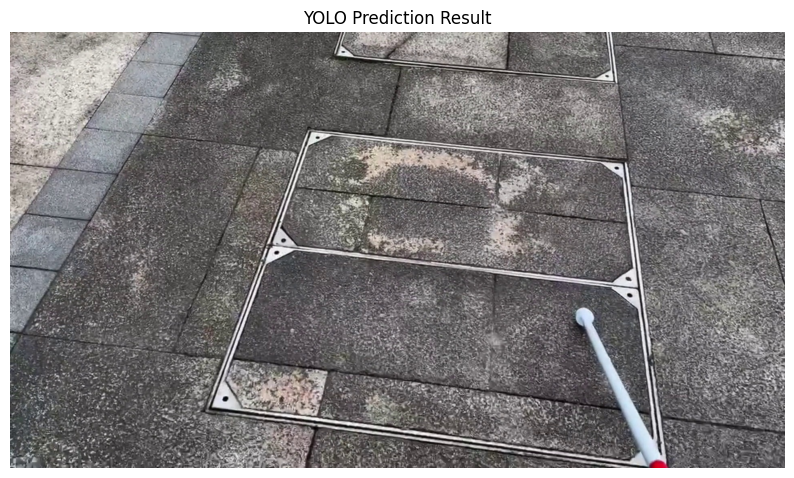

In [7]:
results_dir = "runs/segment/predict"

predicted_image_file = os.listdir(results_dir)[0]

predicted_image_path = os.path.join(results_dir, predicted_image_file)

image = Image.open(predicted_image_path)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title("YOLO Prediction Result")
plt.show()

In [8]:
masks = results[0].masks
mask_data = []
if masks is not None:
    for i, mask in enumerate(masks.xyn):
        #print(f"Mask {i + 1} normalized coordinates:")
        mask_data = np.vstack(mask)
        print(mask_data)
else:
    print("No masks found in the prediction results.")

No masks found in the prediction results.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Intersected Grid Cells: []


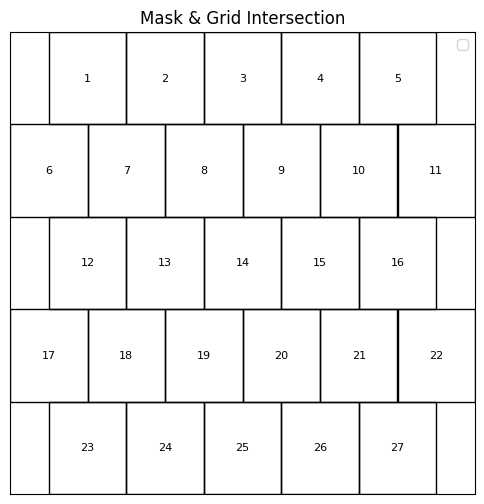

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

def create_grid():
    """Create offset chessboard grid based on the corrected structure"""
    rows = [5, 6, 5, 6, 5]
    cell_w = 1 / 6 
    cell_h = 1 / 5
    grid = []
    
    for r in range(5):
        num_cols = rows[r]
        x_offset = (1 / 12) if r % 2 == 0 else 0
        
        for c in range(num_cols):
            x1, y1 = (c * cell_w) + x_offset, r * cell_h
            x2, y2 = x1 + cell_w, y1 + cell_h
            grid.append((x1, -y1, x2, -y2)) 
    
    return grid

def normalize_coordinates(mask_coords):
    """Normalization"""
    return [(float(x), -float(y)) for x, y in mask_coords] 

def extract_masks(masks):
    """Extract data"""
    extracted_masks = []
    if masks is not None:
        for mask in masks.xyn:
            extracted_masks.append(normalize_coordinates(mask.tolist())) 
    return extracted_masks

def compute_overlap(mask_polygon, cell_polygon):
    """Compute overlapping area"""
    intersection = mask_polygon.intersection(cell_polygon)
    return intersection.area if intersection.is_valid else 0

def find_intersecting_cells(grid, masks, threshold=225):
    """Find intersection and filter cells based on pixel threshold"""
    grid_polygons = [Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]) for (x1, y1, x2, y2) in grid]
    intersected_cells = set()
    
    for mask_coords in masks:
        mask_polygon = Polygon(mask_coords)
        for i, cell in enumerate(grid_polygons):
            overlap_area = compute_overlap(mask_polygon, cell)
            #print(overlap_area)
            if overlap_area *102400 >= threshold: 
                intersected_cells.add(i + 1) 
    
    return sorted(intersected_cells)

def visualize(grid, masks, intersected_cells):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for i, (x1, y1, x2, y2) in enumerate(grid):
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='black', facecolor='none', linewidth=1)
        ax.add_patch(rect)
        ax.text((x1 + x2) / 2, (y1 + y2) / 2, str(i+1), ha='center', va='center', fontsize=8)
    
    for mask in masks:
        mask_polygon = Polygon(mask)
        x, y = mask_polygon.exterior.xy
        ax.fill(x, y, color='blue', alpha=0.3, label='Mask' if 'Mask' not in ax.get_legend_handles_labels()[1] else "")
    
    for idx in intersected_cells:
        x1, y1, x2, y2 = grid[idx-1]
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='red', alpha=0.5)
        ax.add_patch(rect)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Mask & Grid Intersection")
    ax.legend()
    plt.show()

# Run
grid = create_grid()
masks = results[0].masks
mask_data = extract_masks(masks)
intersected_cells = find_intersecting_cells(grid, mask_data, threshold=75)
print("Intersected Grid Cells:", intersected_cells)

# Visualize
visualize(grid, mask_data, intersected_cells)